# Exploring Data
This notebook reads and explores the Nike Kaepernick dataset.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import mglearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import OPTICS

In [2]:
#set random seed
RANDOM_SEED = 655

In [3]:
#read file
df = pd.read_json("./intermediate_data/cleaned_tweet_data.json")

In [4]:
df.head()

,user_created_at,tweet_full_text,tweet_favorite_count,tweet_created_at,user_name,user_profile_image_url_https,user_profile_sidebar_border_color,user_profile_sidebar_fill_color,user_profile_text_color,user_profile_use_background_image,user_screen_name,user_profile_background_color,user_friends_count,user_followers_count,user_description,user_location,user_location_State,state_political_values,tweet_w_user_descript,tweet_favorited
0,2015-05-08 10:27:51+00:00,done is better than perfect. — sheryl sandberg...,0,2018-09-07 16:25:06+00:00,Ultra YOU Woman,https://pbs.twimg.com/profile_images/597000926...,C0DEED,DDEEF6,333333,True,UltraYOUwoman,C0DEED,48721,57983,i share tips to achieve your health goals and ...,"California, USA",CA,Democrat,done is better than perfect. — sheryl sandberg...,False
1,2008-12-26 09:30:23+00:00,hero fdny likesforlikes promo music instagood ...,0,2018-09-07 16:24:59+00:00,Yung Cut Up (Videos),https://pbs.twimg.com/profile_images/945333114...,FFFFFF,EFEFEF,333333,True,yungcutup,131516,5489,13241,all business inquiries contact cluuxxgmail.com...,"Miami, Florida",FL,Republican,hero fdny likesforlikes promo music instagood ...,False
2,2009-04-17 23:04:15+00:00,just do it 4your morning 4your meme cookie f...,0,2018-09-07 16:24:50+00:00,Rachel Bogle,https://pbs.twimg.com/profile_images/986345956...,FFFFFF,FC6A71,050505,True,rachelbogle,FFFAFF,2386,11377,morning traffic reporter cbs 4indy | traffic a...,"Indianapolis, IN",IN,Republican,just do it 4your morning 4your meme cookie f...,False
3,2010-08-08 02:02:56+00:00,kapernickeffect swoosh justdoit lucas bishop'...,0,2018-09-07 16:24:44+00:00,Ervin Youngblood,https://pbs.twimg.com/profile_images/724407937...,C0DEED,DDEEF6,333333,True,ErvGotti609,C0DEED,965,218,"giants, mets, 7 6ers, penguins, florida state,...",Tennessee by way of New Jersey,TN,Republican,kapernickeffect swoosh justdoit lucas bishop'...,False
5,2008-07-23 16:43:42+00:00,real donald trump it's time for me to stock up...,0,2018-09-07 16:24:35+00:00,tazman69,https://pbs.twimg.com/profile_images/743752426...,C0DEED,DDEEF6,333333,True,tazman69,C0DEED,175,64,"enjoys cycling, running & spending a relaxing ...","Austin, TX",TX,Republican,real donald trump it's time for me to stock up...,False


In [5]:
df_nike = df[df['tweet_full_text'].str.contains("nike")]

In [6]:
with open("data/stopwords.txt", "r") as fp:
    stopwords = json.load(fp)

In [7]:
def token_counter(full_text): # df_nike.tweet_full_text
    tweet_re_tokens = Counter()

    for tweet in tqdm(full_text):
    
        pattern_2 = re.compile("[\w]+")
        tweet_re_tokens_updater = []
        for i in tweet.split():
            point =  re.findall(pattern_2, i)
            try:
                if len(point[0]) > 2:
                    if point[0] not in stopwords:
                        if point[0] != 'nike':
                            tweet_re_tokens_updater += point
            except:
                pass

        tweet_re_tokens.update(tweet_re_tokens_updater)
    return tweet_re_tokens

## Most Common Words in Tweets
Here I identify the 25 most common words used in the tweets (excluding the word Nike)

100%|██████████| 995/995 [00:00<00:00, 15939.64it/s]


Number of Tokens: 3837


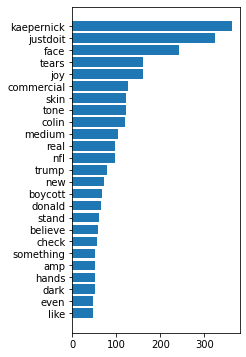

In [8]:
tweet_re_tokens = token_counter(df_nike.tweet_full_text)
print("Number of Tokens:", len(tweet_re_tokens))

df_tweet = pd.DataFrame(tweet_re_tokens.most_common(25), columns =['Word', 'Count'])

plt.figure(figsize=(3, 6))
plt.barh(df_tweet['Word'], df_tweet['Count'])
plt.gca().invert_yaxis()

## Most Common Words in User Descriptions
Here I identify the 25 most common words used in the self description of the users who sent the tweets

100%|██████████| 995/995 [00:00<00:00, 17898.24it/s]


Number of Tokens: 4609


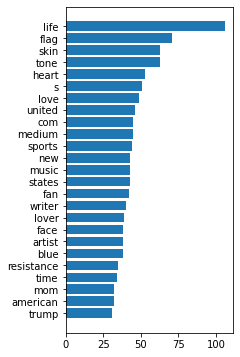

In [9]:
descript_re_tokens = token_counter(df_nike.user_description)

print("Number of Tokens:", len(descript_re_tokens))

df_descript = pd.DataFrame(descript_re_tokens.most_common(25), columns =['Word', 'Count'])

plt.figure(figsize=(3, 6))
plt.barh(df_descript['Word'], df_descript['Count'])
plt.gca().invert_yaxis()

## Topics for Tweets
Here I identify five topics in the tweets using Latent Dirichlet Allocation.

In [10]:
vect = CountVectorizer(max_features = 10_000, max_df = 0.10, stop_words="english")

X = vect.fit_transform(df_nike.tweet_full_text)

size = 5


lda = LatentDirichletAllocation(n_components=size, learning_method='batch', max_iter=25, random_state=RANDOM_SEED)

document_topics = lda.fit_transform(X)

sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

feature_names = np.array(vect.get_feature_names())


mglearn.tools.print_topics(topics=range(size), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
nfl           face          amp           skin          new           
kickoff       tears         people        tone          crazy         
boycott       joy           like          medium        boycott       
football      believe       stand         real          nikes         
kap           means         thank         donald        shoes         
like          sacrificing   ad            dark          stand         
did           real          don           hands         ad            
thanks        ad            boycott       trump         work          
payless       new           right         check         pair          
think         campaign      trump         ad            real          
really        boycott       black         raised        amp           
good          crying        new           fist          buy           
don   

### Topics
- Topic 0) NFL: Focuses on on the NFL kickoff, this could be in reference to an NFL game that occured on this date during which the ad was played during the game. This group is likely interested primarily in the topic of football.
- Topic 1) Face with tears of joy (😂): Used as emoji may indicate a cynical reaction to the campaign, seeing it as a funny event rather than a smart, bold, or creative one. This may be focused on the topic of advertising and brand campaigns rather than football or  political issues such as Black Lives Matter.
- Topic 2) Amp: difficult to decipher what this is indicating, no clear theme
- Topic 3) Medium skin tone (✊🏽): used as emoji to represent the Black Lives Matter movement. This group is likely primarily interested in the topics of Black Lives Matter and police brutality in America.
- Topic 4) New and Crazy: difficult to decipher what this is indicating, no clear theme


## Topics for Users
Here I identify five topics in the user descriptions of tweeters using Latent Dirichlet Allocation.

In [11]:
vect = CountVectorizer(max_features = 10_000, max_df = 0.10, stop_words="english")

X = vect.fit_transform(df_nike.user_description)

size = 5

lda = LatentDirichletAllocation(n_components=size, learning_method='batch', max_iter=25, random_state=RANDOM_SEED)

document_topics = lda.fit_transform(X)

sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

feature_names = np.array(vect.get_feature_names())


mglearn.tools.print_topics(topics=range(size), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
life          tone          life          flag          life          
white         skin          world         united        music         
fan           medium        follow        states        writer        
new           dark          just          trump         mom           
love          pointing      media         blue          black         
small         index         ig            com           artist        
square        backhand      virgo         wave          hip           
face          light         time          resistance    hop           
red           heart         artist        creative      lover         
heart         life          american      maga          com           
team          face          lover         heart         time          
family        flag          work          proud         small         
smilin

### Topics
- Topic 0) Fan: This group is likely comprised of sports fans.
- Topic 1) Medium skin tone (✊🏽): used as emoji to represent the Black Lives Matter movement. This group is likely primarily interested in the topics of Black Lives Matter and police brutality in America.
- Topic 2) Life, World: difficult to decipher what this is indicating, no clear theme
- Topic 3) Flag United States (🇺🇸), Trump: This group is likely comprised of Americans with strong feelings for or against former president, Donald Trump.
- Topic 4) Life, Music, Writer: difficult to decipher what this is indicating, no clear theme

## Clusters of Tweets
Here I identify five clusters of tweets based on their text using k-means clustering.

In [12]:
#creating vector
vectorizer_tweets = TfidfVectorizer(min_df=20, stop_words='english')
X_tweets = vectorizer_tweets.fit_transform(df_nike.tweet_full_text)

In [13]:
# fitting model
kmeans_tweets = KMeans(n_clusters=5, random_state=RANDOM_SEED).fit(X_tweets)

In [14]:
#adding labels to dataframe
df_nike['tweet_labels'] = kmeans_tweets.labels_

/Users/nicolascap/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Clusters of Users
Here I identify five clusters of users based on their user decriptions using k-means clustering.

In [15]:
#creating vector
vectorizer_descript = TfidfVectorizer(min_df=20, stop_words='english')
X_descript = vectorizer_descript.fit_transform(df_nike.user_description)

In [17]:
# fitting model
kmeans_descript = KMeans(n_clusters=5, random_state=RANDOM_SEED).fit(X_descript)

In [18]:
df_nike['user_labels'] = kmeans_descript.labels_

/Users/nicolascap/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Plot Clusters of Users by Users
Here I identify the top 20 words used in the user descriptions of each cluster.

100%|██████████| 809/809 [00:00<00:00, 17663.40it/s]


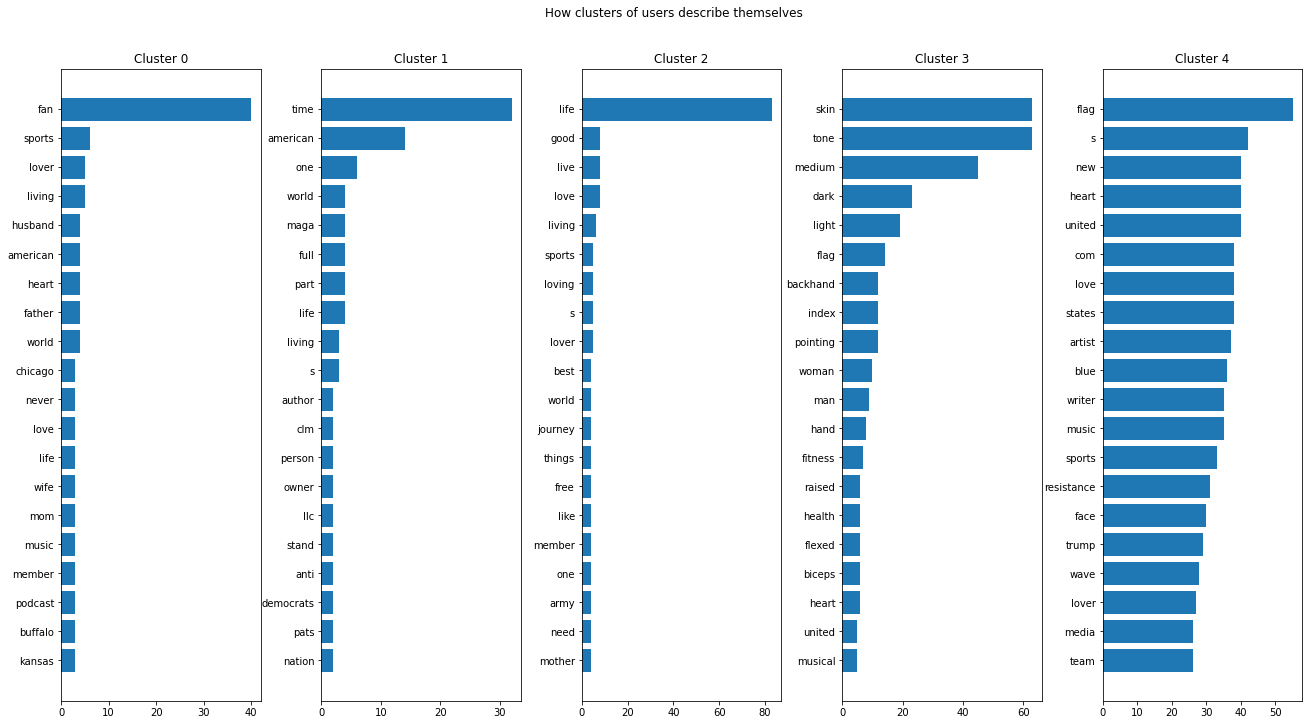

In [19]:
text_list = []
count_list = []
label_list = []
for labeler in range(5):
    df_group = df_nike[df_nike['user_labels'] == labeler]
    df_group_tokens = token_counter(df_group.user_description).most_common(20)
    word, count = list(zip(*df_group_tokens))
    label = [labeler] * len(word)
    text_list = text_list + list(word)
    count_list = count_list + list(count)
    label_list = label_list + label

user_labels_df = pd.DataFrame(
    {'word': text_list,
     'count': count_list,
     'label': label_list
    })

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
fig.suptitle('How clusters of users describe themselves')
final_df = user_labels_df
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=3.0)
xy_point = final_df[final_df.label ==0]
ax0.barh(xy_point['word'], xy_point['count'])
ax0.invert_yaxis()
ax0.title.set_text('Cluster 0')

xy_point = final_df[final_df.label ==1]
ax1.barh(xy_point['word'], xy_point['count'])
ax1.invert_yaxis()
ax1.title.set_text('Cluster 1')

xy_point = final_df[final_df.label ==2]
ax2.barh(xy_point['word'], xy_point['count'])
ax2.invert_yaxis()
ax2.title.set_text('Cluster 2')

xy_point = final_df[final_df.label ==3]
ax3.barh(xy_point['word'], xy_point['count'])
ax3.invert_yaxis()
ax3.title.set_text('Cluster 3')

xy_point = final_df[final_df.label ==4]
ax4.barh(xy_point['word'], xy_point['count'])
ax4.invert_yaxis()
ax4.title.set_text('Cluster 4')

### Themes of Clustered Groups
- Cluster 0) Sports Fans: This groups likely consists of sports fans
- Cluster 1) Timely Americans: This groups likely consists of Americans. Time is used in many ways ('time for change, 'about time', 'I from time to time...') without a clear theme.
- Cluster 2) Lovers of Life: Life is used in many ways ('living my best life', 'life is good', ect.) without a clear theme
- Cluster 3) People of Color: This group consists of individuals that identify as people of color.
- Cluster 4) Proud Divided Americans: This group consists of Americans using the U.S. flag emoji.



## Plot Clusters of Text by Users
Here I identify the top 25 words used in the user descriptions of each cluster.

100%|██████████| 809/809 [00:00<00:00, 13441.84it/s]


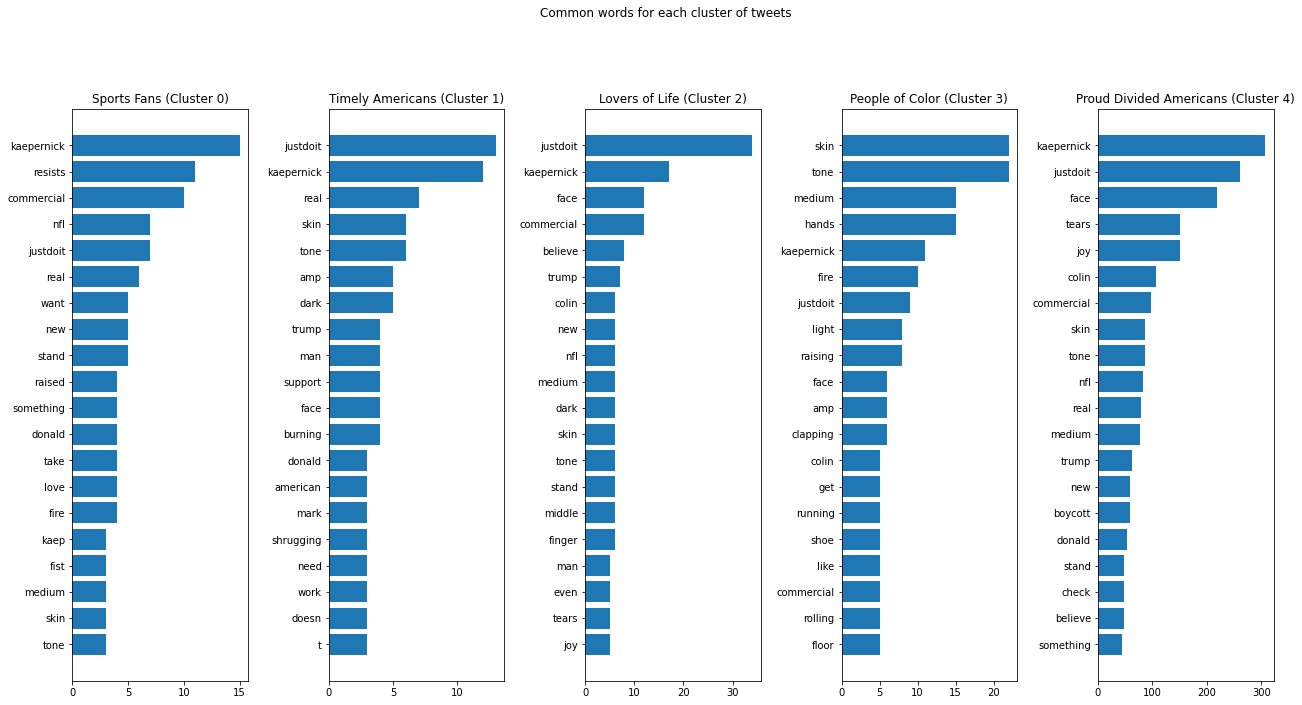

In [21]:
text_list = []
count_list = []
label_list = []
for labeler in range(5):
    df_group = df_nike[df_nike['user_labels'] == labeler]
    df_group_tokens = token_counter(df_group.tweet_full_text).most_common(20)
    word, count = list(zip(*df_group_tokens))
    label = [labeler] * len(word)
    text_list = text_list + list(word)
    count_list = count_list + list(count)
    label_list = label_list + label

text_labels_df = pd.DataFrame(
    {'word': text_list,
     'count': count_list,
     'label': label_list
    })

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
fig.suptitle('Common words for each cluster of tweets')
final_df = text_labels_df
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=5.0)
xy_point = final_df[final_df.label ==0]
ax0.barh(xy_point['word'], xy_point['count'])
ax0.invert_yaxis()
ax0.title.set_text('Sports Fans (Cluster 0)')

xy_point = final_df[final_df.label ==1]
ax1.barh(xy_point['word'], xy_point['count'])
ax1.invert_yaxis()
ax1.title.set_text('Timely Americans (Cluster 1)')

xy_point = final_df[final_df.label ==2]
ax2.barh(xy_point['word'], xy_point['count'])
ax2.invert_yaxis()
ax2.title.set_text('Lovers of Life (Cluster 2)')

xy_point = final_df[final_df.label ==3]
ax3.barh(xy_point['word'], xy_point['count'])
ax3.invert_yaxis()
ax3.title.set_text('People of Color (Cluster 3)')

xy_point = final_df[final_df.label ==4]
ax4.barh(xy_point['word'], xy_point['count'])
ax4.invert_yaxis()
ax4.title.set_text('Proud Divided Americans (Cluster 4)')

### Themes of Tweets by Group
- Cluster 0) Sports Fans: Focus on Kaepernick, likely interested in the Nike campeign from the sports side. 
- Cluster 1) Timely Americans: Focus on Justdoit slogan. Hard to decipher clear reason why
- Cluster 2) Lovers of Life: Focus on Justdoit slogan. Hard to decipher clear reason why
- Cluster 3) People of Color: Heavy use of clapping hands with medium skin tone emoji (👏🏽) likely in support of the themes of the campaign, standing up for Black lives, protesting against police brutality over the athlete involved.
- Cluster 4) Proud Divided Americans: Heavy use of face with tears of joy emoji (😂): Appears to be a mixed reaction of tweets for, against, and cynical of the campaign.


## Plot Clusters of Users Descriptions by Tweets Labels
Here I identify the top 25 words use in the user decriptions of each cluster of tweets.

100%|██████████| 89/89 [00:00<00:00, 23925.97it/s]


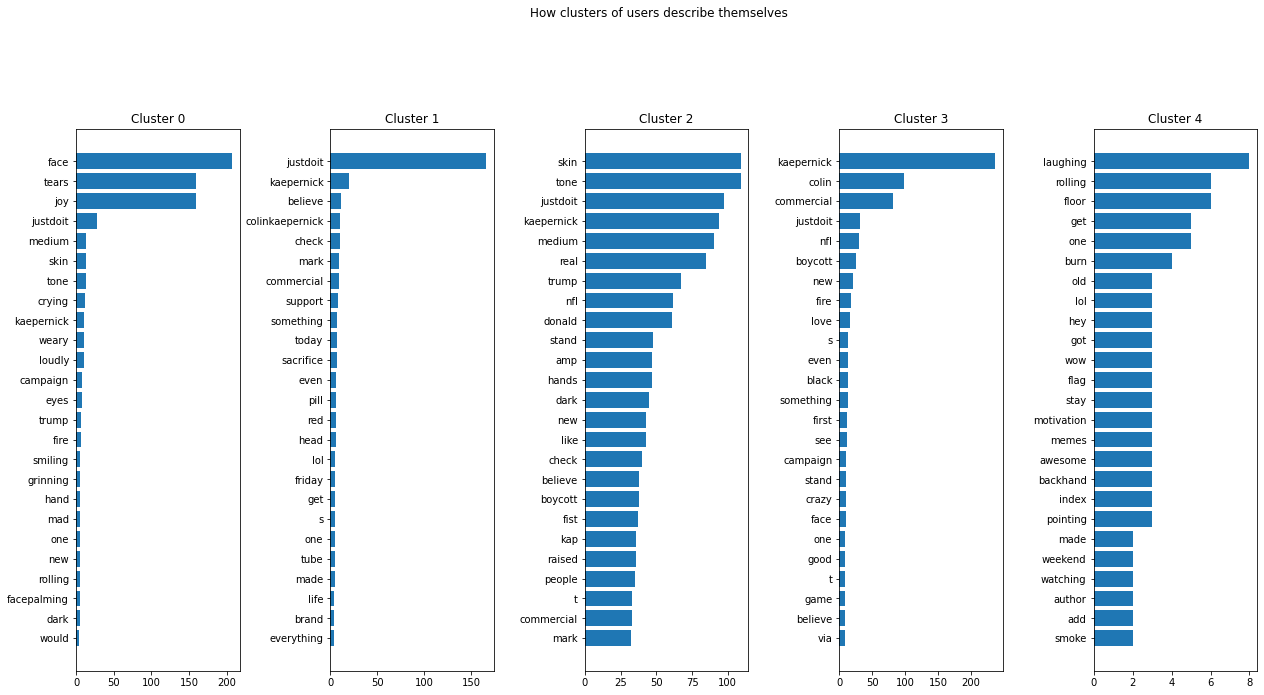

In [22]:
text_list = []
count_list = []
label_list = []
for labeler in range(5):
    df_group = df_nike[df_nike['tweet_labels'] == labeler]
    df_group_tokens = token_counter(df_group.tweet_full_text).most_common(25)
    #tweet_full_text
    #user_description
    word, count = list(zip(*df_group_tokens))
    label = [labeler] * len(word)
    text_list = text_list + list(word)
    count_list = count_list + list(count)
    label_list = label_list + label

text_labels_df = pd.DataFrame(
    {'word': text_list,
     'count': count_list,
     'label': label_list
    })

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
fig.suptitle('How clusters of users describe themselves')
final_df = text_labels_df
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=6.0)
xy_point = final_df[final_df.label ==0]
ax0.barh(xy_point['word'], xy_point['count'])
ax0.invert_yaxis()
ax0.title.set_text('Cluster 0')

xy_point = final_df[final_df.label ==1]
ax1.barh(xy_point['word'], xy_point['count'])
ax1.invert_yaxis()
ax1.title.set_text('Cluster 1')

xy_point = final_df[final_df.label ==2]
ax2.barh(xy_point['word'], xy_point['count'])
ax2.invert_yaxis()
ax2.title.set_text('Cluster 2')

xy_point = final_df[final_df.label ==3]
ax3.barh(xy_point['word'], xy_point['count'])
ax3.invert_yaxis()
ax3.title.set_text('Cluster 3')

xy_point = final_df[final_df.label ==4]
ax4.barh(xy_point['word'], xy_point['count'])
ax4.invert_yaxis()
ax4.title.set_text('Cluster 4')

### Themes of Clustered Tweets
- Cluster 0) Face tears joy (😂): This group consists of tweets using the (😂) emoji. This group finds the campaign more humorous than anything.
- Cluster 1) Justdoit: This groups consists of tweets that use #justdoit. This group may consist of people more interested in Nike the company than the campaign itself.
- Cluster 2) Divided Americans: This group consists of emojis that make references to people of color and tweets at @realdonaldtrump. This group is likely interested in the campaign from a political perspective (Black Lives Matter and police brutality).
- Cluster 3) Kaepernick: This group consists of tweets at or mentioning Colin Kaepernick. This group is likely interested in the sports angle of the campaign.
- Cluster 4) Rolling floor laughing (🤣): This group consists of tweets using the (🤣 ) emoji. This group finds the campaign more humorous than anything




100%|██████████| 89/89 [00:00<00:00, 12521.57it/s]


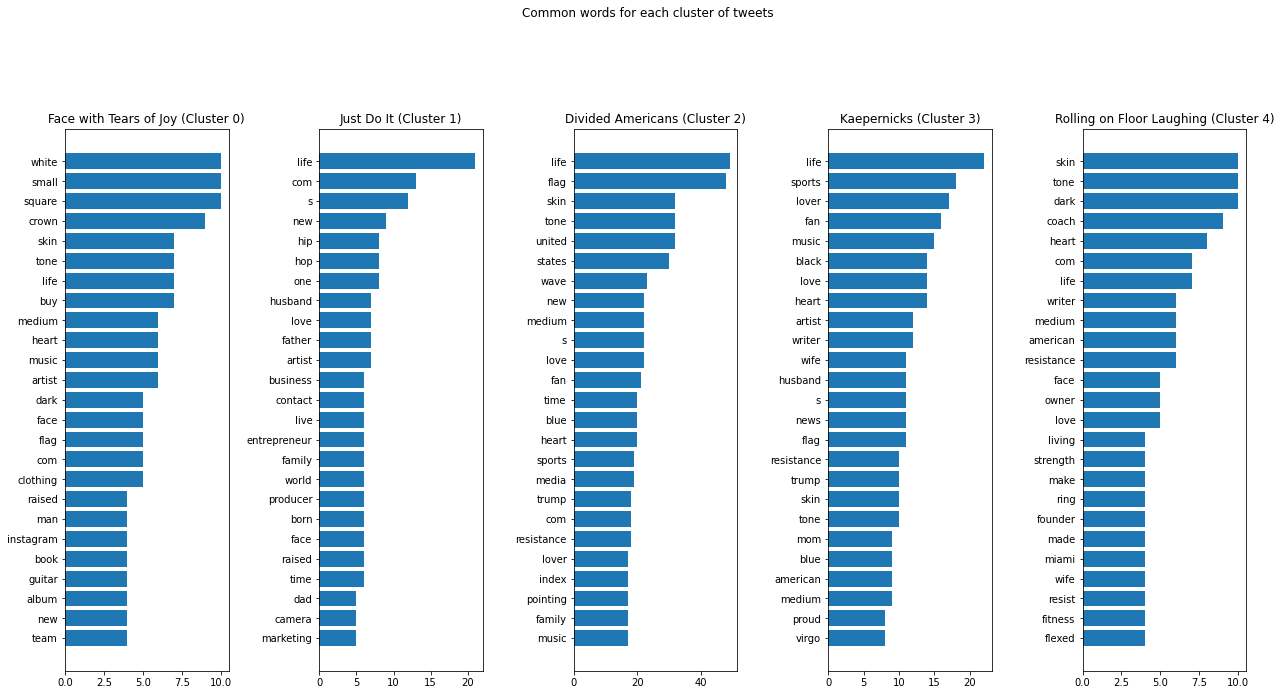

In [24]:
text_list = []
count_list = []
label_list = []
for labeler in range(5):
    df_group = df_nike[df_nike['tweet_labels'] == labeler]
    df_group_tokens = token_counter(df_group.user_description).most_common(25)
    #user_description
    word, count = list(zip(*df_group_tokens))
    label = [labeler] * len(word)
    text_list = text_list + list(word)
    count_list = count_list + list(count)
    label_list = label_list + label

text_labels_df = pd.DataFrame(
    {'word': text_list,
     'count': count_list,
     'label': label_list
    })

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
fig.suptitle('Common words for each cluster of tweets')
final_df = text_labels_df
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=6.0)
xy_point = final_df[final_df.label ==0]
ax0.barh(xy_point['word'], xy_point['count'])
ax0.invert_yaxis()
ax0.title.set_text('Face with Tears of Joy (Cluster 0)')

xy_point = final_df[final_df.label ==1]
ax1.barh(xy_point['word'], xy_point['count'])
ax1.invert_yaxis()
ax1.title.set_text('Just Do It (Cluster 1)')

xy_point = final_df[final_df.label ==2]
ax2.barh(xy_point['word'], xy_point['count'])
ax2.invert_yaxis()
ax2.title.set_text('Divided Americans (Cluster 2)')

xy_point = final_df[final_df.label ==3]
ax3.barh(xy_point['word'], xy_point['count'])
ax3.invert_yaxis()
ax3.title.set_text('Kaepernicks (Cluster 3)')

xy_point = final_df[final_df.label ==4]
ax4.barh(xy_point['word'], xy_point['count'])
ax4.invert_yaxis()
ax4.title.set_text('Rolling on Floor Laughing (Cluster 4)')

### Themes of Group Descriptions by Clustered Tweets
- Cluster 0) Face tears joy (😂): The only common theme is the use of a white small square emoji (▫️). Difficult to see a significant theme.
- Cluster 1) Justdoit:  The only common theme is the use of word 'life'. Difficult to see a significant theme.
- Cluster 2) Divided Americans: This group consists of medium skin tone emojis (👋🏽) and the American flag emoji (🇺🇸). This group is likely interested in the campaign from a political perspective (Black Lives Matter, and protesting police brutality).
- Cluster 3) Kaepernick: This group has a theme of referencing a love of sports. This group is likely interested in the sports.
- Cluster 4) Rolling floor laugning (🤣): This group consists of tweets using the () emoji. This group finds the campaign humorous

## Clusters of Tweets Accounting for Non-Text Data Points
Here I identify five clusters of tweets based on their text using k-means clustering. This k-means algorithm that generates the clusters uses not only the text of the tweet and user description but also the year of account creation, the hour of tweet creation, the user follower count and more.

In [25]:
df_nike_clustering_0 = df_nike[['user_created_at', 'tweet_favorite_count', 'tweet_created_at',
         'user_friends_count', 'user_followers_count']].copy()

df_nike_clustering_0['tweet_created_at'] = df_nike_clustering_0.tweet_created_at.dt.hour

df_nike_clustering_0['user_created_at'] = df_nike_clustering_0.user_created_at.dt.year

states = pd.get_dummies(df_nike.user_location_State)

df_nike_clustering = pd.concat([df_nike_clustering_0, states], axis=1)



In [26]:
df1 = pd.DataFrame(X_descript.toarray(), columns=vectorizer_descript.get_feature_names())

df2 = pd.DataFrame(X_tweets.toarray(), columns=vectorizer_tweets.get_feature_names())



In [27]:
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array)

res = pd.concat([df_nike_clustering.reset_index(drop=True), df1], axis=1)

scaler = MinMaxScaler()

res['user_created_at'] = scaler.fit_transform(res.user_created_at.to_numpy().reshape(-1, 1))
    
res['tweet_favorite_count'] = scaler.fit_transform(res.tweet_favorite_count.to_numpy().reshape(-1, 1))

res['tweet_created_at'] = scaler.fit_transform(res.tweet_created_at.to_numpy().reshape(-1, 1))

res['user_friends_count'] = scaler.fit_transform(res.user_friends_count.to_numpy().reshape(-1, 1))

res['user_followers_count'] = scaler.fit_transform(res.user_followers_count.to_numpy().reshape(-1, 1))


kmeans_major = KMeans(n_clusters=5, random_state=RANDOM_SEED).fit(res)

df_nike['major_labels'] = kmeans_major.labels_

/Users/nicolascap/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Major Tweet Analysis

100%|██████████| 116/116 [00:00<00:00, 9458.57it/s]


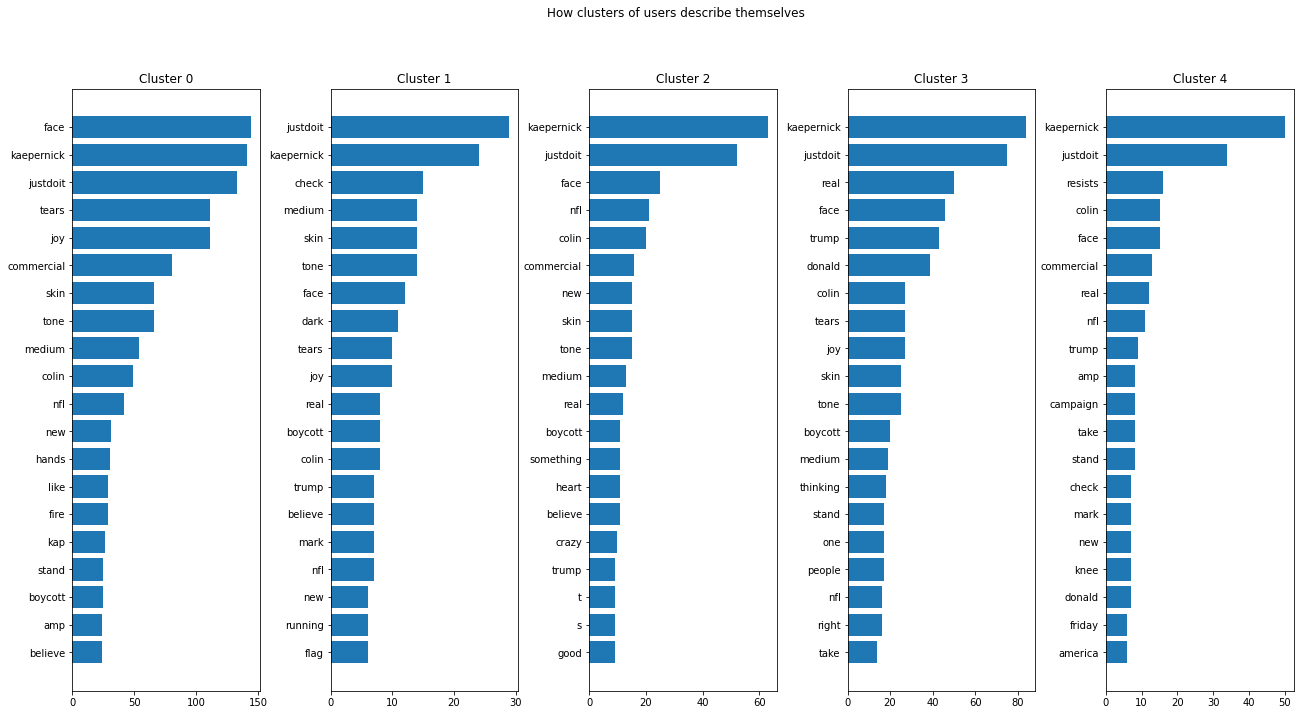

In [28]:
text_list = []
count_list = []
label_list = []
for labeler in range(5):
    df_group = df_nike[df_nike['major_labels'] == labeler]
    df_group_tokens = token_counter(df_group.tweet_full_text).most_common(20)
    
    word, count = list(zip(*df_group_tokens))
    label = [labeler] * len(word)
    text_list = text_list + list(word)
    count_list = count_list + list(count)
    label_list = label_list + label

user_labels_df = pd.DataFrame(
    {'word': text_list,
     'count': count_list,
     'label': label_list
    })

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
fig.suptitle('How clusters of users describe themselves')
final_df = user_labels_df
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=4.0)

xy_point = final_df[final_df.label ==0]
ax0.barh(xy_point['word'], xy_point['count'])
ax0.invert_yaxis()
ax0.title.set_text('Cluster 0')

xy_point = final_df[final_df.label ==1]
ax1.barh(xy_point['word'], xy_point['count'])
ax1.invert_yaxis()
ax1.title.set_text('Cluster 1')

xy_point = final_df[final_df.label ==2]
ax2.barh(xy_point['word'], xy_point['count'])
ax2.invert_yaxis()
ax2.title.set_text('Cluster 2')

xy_point = final_df[final_df.label ==3]
ax3.barh(xy_point['word'], xy_point['count'])
ax3.invert_yaxis()
ax3.title.set_text('Cluster 3')

xy_point = final_df[final_df.label ==4]
ax4.barh(xy_point['word'], xy_point['count'])
ax4.invert_yaxis()
ax4.title.set_text('Cluster 4')

## Major User Description Analysis

100%|██████████| 116/116 [00:00<00:00, 15353.57it/s]


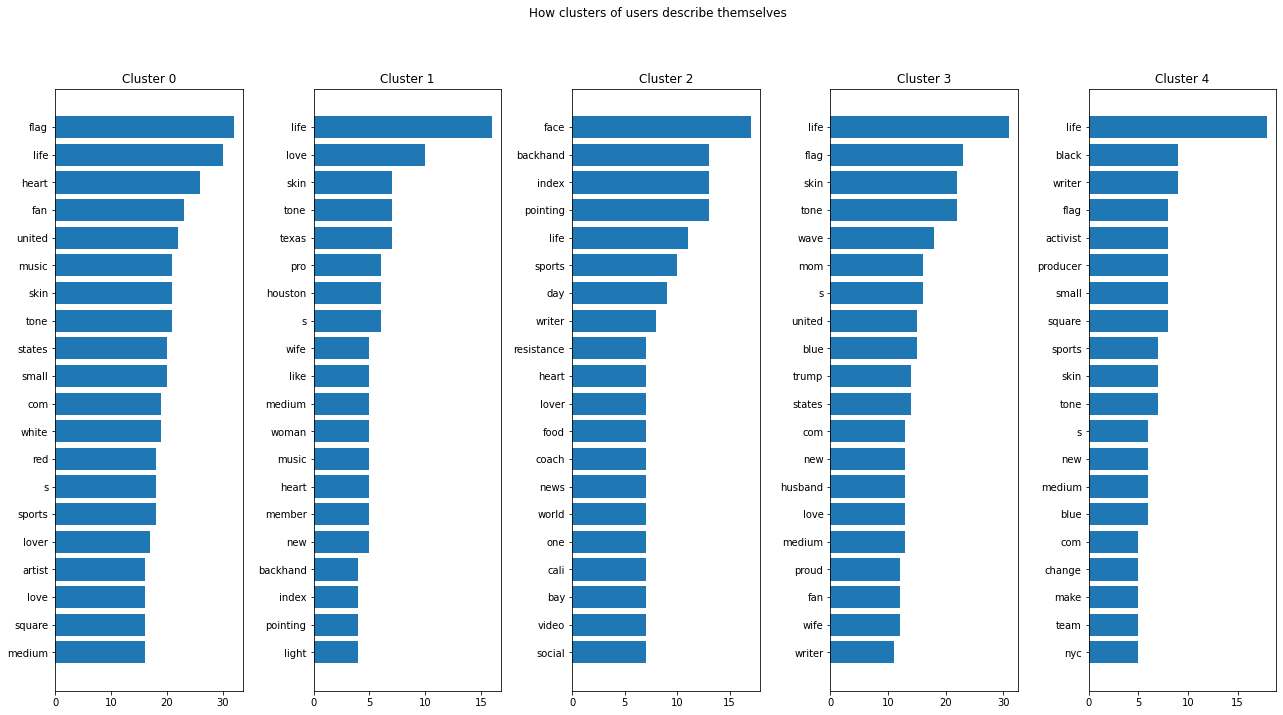

In [29]:
text_list = []
count_list = []
label_list = []
for labeler in range(5):
    df_group = df_nike[df_nike['major_labels'] == labeler]
    df_group_tokens = token_counter(df_group.user_description).most_common(20)

    word, count = list(zip(*df_group_tokens))
    label = [labeler] * len(word)
    text_list = text_list + list(word)
    count_list = count_list + list(count)
    label_list = label_list + label

user_labels_df = pd.DataFrame(
    {'word': text_list,
     'count': count_list,
     'label': label_list
    })

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5)
fig.suptitle('How clusters of users describe themselves')
final_df = user_labels_df
fig.set_size_inches(18.5, 10.5)
fig.tight_layout(pad=4.0)

xy_point = final_df[final_df.label ==0]
ax0.barh(xy_point['word'], xy_point['count'])
ax0.invert_yaxis()
ax0.title.set_text('Cluster 0')

xy_point = final_df[final_df.label ==1]
ax1.barh(xy_point['word'], xy_point['count'])
ax1.invert_yaxis()
ax1.title.set_text('Cluster 1')

xy_point = final_df[final_df.label ==2]
ax2.barh(xy_point['word'], xy_point['count'])
ax2.invert_yaxis()
ax2.title.set_text('Cluster 2')

xy_point = final_df[final_df.label ==3]
ax3.barh(xy_point['word'], xy_point['count'])
ax3.invert_yaxis()
ax3.title.set_text('Cluster 3')

xy_point = final_df[final_df.label ==4]
ax4.barh(xy_point['word'], xy_point['count'])
ax4.invert_yaxis()
ax4.title.set_text('Cluster 4')

### Themes of Groups
- Cluster 0) Reacting to the commercial: This group appear to be clustered around tweets that use emojis to react the event. These emojis include the face with tears of joy (😂), hands with medium skin tone (👏🏽), and fire (🔥)
- Cluster 1) Texans: This group appears to be around tweets that are sent from Texas. 
- Cluster 2) Californians: This group appears to be around tweets that are sent from California. 
- Cluster 3) Tweeting at Trump: This group appears to be around tweets that are interested in the political side of the commercial, many describe themselves as "activists" can can be seen tweeting @realdonaldtrump
- Cluster 4) New Yorkers: This group appears to be around tweets that are sent from New York. Because this is Donald Trump's home state, it might explain why he is referenced at a higher rate than the "Texas" or "California" cluster

## Results
The different exploration methods used in this page suggest several things about the reaction to the campaign on twitter and how it may inform Nike's brand strategy going forward.

The models used identified three different ways in which the tweeters could be grouped:
* How they self-identify
* How they reacted to the campaign
* Where they are from geographically


Based on how they identify the tweeters were grouped into three groups:
* Fans
* People of Color
* Proud Americans

Based on how they reacted to the campaign the tweeters are grouped into four groups:
* Focusing on the racial component of the campaign as evidenced by heavy use of medium skinned emojis
* Focusing on the sport component of the campaign as evidenced by heavy references to Kaepernick and the NFL
* Focusing on the Trump component (Trump's reaction to the campaign) as evidenced by the heavy use of Donald Trump's Twitter handle 
* Focusing on the comedic component of the campaign as evidenced by the heavy use of the laughing emoji

Based on where they where from geographically, the tweeters were grouped into three main groups:
* Tweeters from Texas
* Tweeters from California
* Tweeters from New York





## Next Step
After you saved the dataset here, run the next step in the workflow [3-FitPredictFavoriting.ipynb](./3-FitPredictFavoriting.ipynb) or go back go back to [0-Workflow.ipynb](./0-Workflow.ipynb).

---

**Author:** [Nick Capaldini](mailto:nickcaps@umich.edu), University of Michigan, January 19, 2022

---